## 1. Introduction

This project will explore and analyze the information stored in a particular dataset. In this case, the ACL Anthology dataset (https://aclanthology.org/). We will explore different techniques for obtaining valuable information.

### Task 3: Graphs and Social Networks

Using the whole anthologies abstract dataset.

1. From the abstracts part, using three different similarity thresholds (e.g. 0.05, 0.1, and 0.2), create an unweighted network from the obtained similar pairs (use MinHashing or LSH) for each threshold.

2. From the basket list of authors/editors, using A-Priori or PCY, create a weighted network, using the support threshold as weight.

3. Find the communities for the networks obtained in 1. and 2. Comment about the results with respect to the different thresholds and methods. How does it compare with the same analysis using 1-NN done in previous tasks?

4. Use a ready-made software, library or service (eg. gephi) for visualizing one the network in 1. or 2.Comment your results.

In [1]:
#from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

import pandas as pd
import numpy
import numpy as np
import os
import re
import binascii
from time import time

from urllib import request
import gzip
import shutil
import time

import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
#from sklearn.decomposition import PCA

import matplotlib

import networkx as nx
import matplotlib.pyplot as plt
import itertools

%matplotlib inline

In [2]:
# Download and extract dataset

url1 = "https://aclanthology.org/anthology+abstracts.bib.gz"
file_name1 = re.split(pattern='/', string=url1)[-1]
r1 = request.urlretrieve(url=url1, filename=file_name1)
txt1 = re.split(pattern=r'\.', string=file_name1)[0] + ".txt"

# Extract it
with gzip.open(file_name1, 'rb') as f_in:
    with open(txt1, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

fname = txt1    

In [3]:
# Various Functions
#==================#

# abstract extracting function
# fname is the file name of the document containing all abstract
# n is the number of abstracts that we will extract
def read_abstracts(fname,n):
    abs = [] #initialize a list variable
    with open(fname, 'r', encoding="utf-8") as f:
        i = 0
        # skip all lines until abstract
        for line in f:
            if "abstract =" in line:
                pattern = '"'
                abstract = re.split(pattern ,line, flags=re.IGNORECASE)[1].split('"')[0]
                if len(abstract)<5: # takes care of empty abstracts
                    pass
                    
                else:
                    abs.append(abstract) # append each abstract to the list
                    i = i + 1
                if i == n:  # number of abstracts to extract
                    return abs
        
        return abs
#=================================================
    
# Shingle function
# k is the number of shingles

def get_shingles(abstract, k):
    """Get all shingles from requested file (hashes of these shingles)
    """
    L = len(abstract)
    shingles = set()  # we use a set to automatically eliminate duplicates
    for i in range(L-k+1):
        shingle = abstract[i:i+k]
        crc = binascii.crc32(shingle.encode('utf-8')) # hash the shingle to a 32-bit integer
        shingles.add(crc)
    return shingles
#=================================================

# jaccard similarity score Function
def jaccard_similarity_score(x, y, errors='ignore'):
    """
    Jaccard Similarity J (A,B) = | Intersection (A,B) | /
                                    | Union (A,B) |
    """
    intersection_cardinality = len(set(x).intersection(set(y)))
    union_cardinality = len(set(x).union(set(y)))
    if float(union_cardinality) == 0:
        ja = 0
    else:
        ja = intersection_cardinality / float(union_cardinality)
    return ja
#=================================================

# similarity functions
# k is number of shingles and s is the similarity thresholds 
# abstract_list is the list of 1000 abstracts

def similar_items(abstract_list, k, s):
    candidates = []
    #abstract_list = read_abstracts(fname,n)
    for pair in itertools.combinations(abstract_list,2):
        js = jaccard_similarity_score(get_shingles(pair[0], k),get_shingles(pair[1], k))
        
        if js > s:
            #print(pair)
            candidates.append(pair)
            
    return candidates
#=================================================


# fast implementation of Minhashing algorithm
# computes all random hash functions for a shingle at once, using vector operations
# also finds element-wise minimum of two vectors efficiently
def minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig):
    signature = numpy.ones((nsig,)) * (maxShingleID + 1)

    for ShingleID in shingles:
        hashCodes = ((A*ShingleID + B) % nextPrime) % maxShingleID
        numpy.minimum(signature, hashCodes, out=signature)

    return signature
#=================================================

# candidate pair function
def candidate_pair(abstract_list, k, s):
    signatures = []  # signatures for all files
    for abstract in abstract_list:
        shingles = get_shingles(abstract, k)
        signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)
        signatures.append(signature)
        
    Nfiles = len(signatures)
    #startTime = time.time()
    candidates = []
    for i in range(Nfiles):
        for j in range(i+1, Nfiles):
            Jsim = numpy.mean(signatures[i] == signatures[j])  # average number of similar items in 
            if Jsim >= s:                                      # two vectors, equivalente to Jaccard
                candidates.append((i,j))
                
            
    return len(candidates)
#=================================================

# Moditied Function for jaccard similarity

def jaccard_similarity_score_mod2(a, b, shingles_list, errors='ignore'): 
    
    sha = shingles_list[a]
    shingles_vector_a = sha
 
    shb = shingles_list[b]
    shingles_vector_b = shb

    jsc = jaccard_similarity_score(shingles_vector_a, shingles_vector_b)
    
    return jsc
#=================================================

# LSH candidates function
def LSH(signatures, bands, rows, Ab, Bb, nextPrime, maxShingleID, s, shingles_list):
    """Locality Sensitive Hashing
    """
    numItems = signatures.shape[1]
    signBands = numpy.array_split(signatures, bands, axis=0) 
    candidates = set()
    for nb in range(bands):
        hashTable = {}
        for ni in range(numItems):
            item = signBands[nb][:,ni]
            hash = (numpy.dot(Ab[nb,:], item) + Bb[nb]) % nextPrime % maxShingleID
            if hash not in hashTable:
                hashTable[hash] = [ni]
            else:
                hashTable[hash].append(ni)
        for _,items in hashTable.items():
            if len(items) > 1:
                L = len(items)
                for i in range(L-1):
                    for j in range(i+1, L):
                        cand = [items[i], items[j]]
                        a = items[i]
                        b = items[j]
                        jsim = jaccard_similarity_score_mod2(a,b, shingles_list) #jaccard similarity function call
                        if jsim >= s:
                            numpy.sort(cand)
                            candidates.add(tuple(cand))
    return candidates
#=================================================

# LSH candidates length function
def LSH_candidates(abstract_list, k, s):
    signatures = []  # signatures for all files
    shingles_list =[]
    for abstract in abstract_list:
        shingles = get_shingles(abstract, k)
        signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)
        signatures.append(signature)
        shingles_list.append(shingles)
        
    
    A2 = numpy.random.randint(0, nextPrime/2, size=(bands, rows),dtype=numpy.int64)  # now we need a vector of A parameters for each band
    B2 = numpy.random.randint(0, nextPrime/2, size=(bands, ),dtype=numpy.int64)
    signatures = numpy.array(signatures).T  # LSH needs a matrix of signatures, not a list of vectors

  
    candidates = LSH(signatures, bands, rows, A2, B2, nextPrime, maxShingleID, s, shingles_list)
   
    
    return len(candidates)
#=================================================

# New minHash function for Task1 number2 a
def Sim_Method_Property(abstract_list,k,s,bands,rows):
    
    nsig = bands*rows  # hashing function: number of elements in signature, or the number of different random hash functions

    #maxShingleID = 2**32-1  # record the maximum shingle ID that we assigned
    #nextPrime = 4294967311  # next prime number after maxShingleID

    #A = numpy.random.randint(0, nextPrime, size=(nsig,),dtype=numpy.int64)
    #B = numpy.random.randint(0, nextPrime, size=(nsig,),dtype=numpy.int64)
    
    startTime = time.time()
    cand = candidate_pair(abstract_list, k, s)
    execTime = round(((time.time() - startTime)),2)

    minHash_k.append(k)
    minHash_s.append(s)
    Hashing_fn.append(nsig)
    minHash_sim.append(cand)
    minHash_execT.append(execTime)
    
    dict = {'k': minHash_k, 's': minHash_s, 'Hashing_fn': Hashing_fn,'#sim': minHash_sim, 'execTime(sec)': minHash_execT} 
    df = pd.DataFrame(dict)
    
    return df
#=================================================

# New LSH function for Task1 number2 b
def Sim_Method_Property2(abstract_list,k,s,bands,rows):
    
    
    nsig = bands*rows  # hashing function: number of elements in signature, or the number of different random hash functions
    
    startTime = time.time()
    candi = LSH_candidates(abstract_list,k, s)
    execTime = round(((time.time() - startTime)),2)
    
    LSH_k.append(k)
    LSH_s.append(s)
    Hashing_fn2.append(nsig)
    LSH_sim.append(candi)
    LSH_execT.append(execTime)
    
    dict = {'k': LSH_k, 's': LSH_s, 'Hashing_fn': Hashing_fn2,'#sim': LSH_sim, 'execTime(sec)': LSH_execT} 
    df = pd.DataFrame(dict)
    
    return df
#=================================================

# functions for Task1 number 3
# Jaccard distance calculator function

def jacc_dist_calc(abstract_list,k,s,bands,rows):
    
    nsig = bands*rows  # hashing function: number of elements in signature, or the number of different random hash functions
    
    jd_df = candidate_pair_jacc_dist(abstract_list, k, s, nsig)

    return jd_df
#==============

# A modified candidate pair function

def candidate_pair_jacc_dist(abstract_list, k, s, nsig):
    signatures = []  # signatures for all files
    shingles_list = []
    for abstract in abstract_list:
        shingles = get_shingles(abstract, k)
        signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)
        signatures.append(signature)
        shingles_list.append(shingles)
        
    Nfiles = len(signatures)
    candidates = []
    jaccard_distance = []
    s_list = []
    #k_list = []
    #h_fn_list = []
    #sign1 = []
    #sign2 = []
    for i in range(Nfiles):
        for j in range(i+1, Nfiles):
            Jsim = numpy.mean(signatures[i] == signatures[j])  # average number of similar items in 
            if Jsim >= s:                                      # two vectors, equivalente to Jaccard
                #a = i
                #b = j
                js = jaccard_similarity_score_mod2(i,j, shingles_list)
                jaccard_distance.append(1-js) # jaccard distance calculations
                s_list.append(s)
                #k_list.append(k)
                #h_fn_list.append(nsig)
                candidates.append((i,j))
                #sign1.append(signatures[i])
                #sign2.append(signatures[j])
    
    dict = {'s': s_list, 'candidates': candidates, 'jacc_distance': jaccard_distance} 
    df = pd.DataFrame(dict)
    return df    #len(candidates)
#=================================================
#=================================================
#=================================================
# naive algorithm function for Task2

def naive_items(s):
    start = time.time() # start time
    
    def get_C(k):
        C = {}
        for key in readdata_hands_on(k):  # False report
            if key not in C:
                C[key] = 1
            else:
                C[key] += 1
        #print("Took {}s for k={}".format((time.time() - start), k))
        return C


    C1 = get_C(1)
    C2 = get_C(2)
    
    
     
    L2 = {}
    for key, n in C2.items():
        if n >= s:
            L2[key] = n
    
    # append results
    s_list.append(s)
    L2_counts_list.append(len(L2))
    Wall_time_list_ns.append(time.time() - start)
    return
#=================================================

# a-priori algorithm function for Task2

def apriori_items(s):
    
    start = time.time() # start time
    N = s
    # find frequent individual items
    C1 = {}
    for key in readdata_hands_on(k=1):
        if key not in C1:
            C1[key] = 1
        else:
            C1[key] += 1    
        
    #print("{} items".format(len(C1)))
    
    # filter stage
    L1 = {}
    for key, count in C1.items():
        if count >= N:
            L1[key] = count
    #print('{} items with >{} occurances'.format(len(L1), N))
    
    # List comprehensions in python
    C2_items = set([a.union(b) for a in L1.keys() for b in L1.keys()]) 
    #print(len(C2_items))
    
    # find frequent 2-tuples
    C2 = {}
    for key in readdata_hands_on(k=2):
        # filter out non-frequent tuples
        if key not in C2_items:
            continue

        # record frequent tuples
        if key not in C2:
            C2[key] = 1
        else:
            C2[key] += 1
        
    #print("{} items".format(len(C2)))
    
    # filter stage
    L2 = {}
    for key, count in C2.items():
        if count >= N:
            L2[key] = count
    #print('A-priori: {} items with >{} occurances'.format(len(L2), N))
    
    # append results
    s_list.append(s)
    L2_counts_list.append(len(L2))
    Wall_time_list_ns.append(time.time() - start)
    return
#=================================================

def readdata_hands_on(k, fname='anthology_authors.csv'):
    
    with open(fname, "rt", encoding='latin1') as f:
        for line in f:
            C_k  = line.rstrip().split(';')
            for itemset in itertools.combinations(C_k, k):
                    yield frozenset(itemset)
#=================================================

# pcy algorithm function

def pcy_items(s):
    
    start = time.time() # start time
    N = s # frequency threshold
    
    # hash table
    max_hash1 = 10 * 1000000
    H1 = np.zeros((max_hash1, ), dtype=np.int)

    for key in readdata_hands_on(k=2):
        hash_cell_1 = hash(key) % max_hash1
        H1[hash_cell_1] += 1
        
    # find frequent individual items
    C1 = {}
    for key in readdata_hands_on(k=1):
        if key not in C1:
            C1[key] = 1
        else:
            C1[key] += 1    
        
    #print("{} items".format(len(C1)))
    
    # filter stage
    L1 = {}
    for key, count in C1.items():
        if count >= N:
            L1[key] = count
    #print('{} items with >{} occurances'.format(len(L1), N))
    
    # List comprehensions in python
    C2_items = set([a.union(b) for a in L1.keys() for b in L1.keys()])
    
    #print(len(C2_items))
    
    # find frequent 2-tuples
    C2 = {}
    for key in readdata_hands_on(k=2):
        # hash-based filtering stage from PCY
        hash_cell_1 = hash(key) % max_hash1
        if H1[hash_cell_1] < N:
            continue

        # filter out non-frequent tuples
        if key not in C2_items:
            continue

        # record frequent tuples
        if key not in C2:
            C2[key] = 1
        else:
            C2[key] += 1
        
    #print("{} items".format(len(C2)))
    
    # filter stage
    L2 = {}
    for key, count in C2.items():
        if count >= N:
            L2[key] = count
    #print('{} items with >{} occurances'.format(len(L2), N))
    
    # append results
    s_list.append(s)
    L2_counts_list.append(len(L2))
    Wall_time_list_ns.append(time.time() - start)
    return L2
#=================================================

def readdata_hands_on2(k,report=False,fname='anthology_authors.csv'):
    
    with open(fname, "rt", encoding='latin1') as f:
        for line in f:
            C_k  = line.rstrip().split(';')
            for itemset in itertools.combinations(C_k, k):
                    yield frozenset(itemset) 
#=================================================
                    
# Task 2 hash tables functions

##### PCY Algorithm

# One compact hash table 
# PCY algorithm function

def oneHashTablePCY(s):
    
    start = time.time() # start time
    N = s # frequency threshold
    
    # hash table
    max_hash1 = 10 * 1000000
    H1 = np.zeros((max_hash1, ), dtype=np.int)

    for key in readdata_hands_on2(k=2, report=False):
        hash_cell_1 = hash(key) % max_hash1
        H1[hash_cell_1] += 1
        
        
    #### === one compact hash table ====####
    H_good_1 = set(np.where(H1 >= N)[0])
    del H1
    
    # find frequent individual items
    C1 = {}
    for key in readdata_hands_on2(k=1):
        if key not in C1:
            C1[key] = 1
        else:
            C1[key] += 1    
        
    #print("{} items".format(len(C1)))
    
    # filter stage
    L1 = {}
    for key, count in C1.items():
        if count >= N:
            L1[key] = count
    #print('{} items with >{} occurances'.format(len(L1), N))
    
    # List comprehensions in python
    C2_items = set([a.union(b) for a in L1.keys() for b in L1.keys()])

    
    # find frequent 2-tuples
    C2 = {}
    for key in readdata_hands_on2(k=2):
        # hash-based filtering stage from PCY
        hash_cell_1 = hash(key) % max_hash1
        if hash_cell_1 not in H_good_1:
            continue

        # filter out non-frequent tuples
        if key not in C2_items:
            continue

        # record frequent tuples
        if key not in C2:
            C2[key] = 1
        else:
            C2[key] += 1
        
    #print("{} items".format(len(C2)))

   
    # filter stage
    L2 = {}
    for key, count in C2.items():
        if count >= N:
            L2[key] = count
    #print('{} items with >{} occurances'.format(len(L2), N))
    
    # append results
    s_list.append(s)
    L2_counts_list.append(len(L2))
    Wall_time_list_ns.append(time.time() - start)
    return
#==============

# Two compact hash table 
# PCY algorithm function

def twoHashTablePCY(s):
    
    start = time.time() # start time
    N = s # frequency threshold
    
    # hash tables
    max_hash1 = 5*1000000-673
    max_hash2 = 5*1000000+673
    
    H1 = np.zeros((max_hash1,), dtype=np.int)
    H2 = np.zeros((max_hash2,), dtype=np.int)

    for key in readdata_hands_on2(k=2, report=False):
        hash_cell_1 = hash(key) % max_hash1
        H1[hash_cell_1] += 1
        hash_cell_2 = hash(key) % max_hash2
        H2[hash_cell_2] += 1
        
    #### === two compact hash tables ====####
    H_good_1 = set(np.where(H1 >= N)[0])
    H_good_2 = set(np.where(H2 >= N)[0])
    del H1
    del H2
    
    # find frequent individual items
    C1 = {}
    for key in readdata_hands_on2(k=1):
        if key not in C1:
            C1[key] = 1
        else:
            C1[key] += 1    
        
    #print("{} items".format(len(C1)))
    
    # filter stage
    L1 = {}
    for key, count in C1.items():
        if count >= N:
            L1[key] = count
    #print('{} items with >{} occurances'.format(len(L1), N))
    
    # List comprehensions in python
    C2_items = set([a.union(b) for a in L1.keys() for b in L1.keys()])

    
    # find frequent 2-tuples
    C2 = {}
    for key in readdata_hands_on2(k=2):
        # hash-based filtering stage from PCY
        hash_cell_1 = hash(key) % max_hash1
        if hash_cell_1 not in H_good_1:
            continue
        
        hash_cell_2 = hash(key) % max_hash2
        if hash_cell_2 not in H_good_2:
            continue
                

        # filter out non-frequent tuples
        if key not in C2_items:
            continue

        # record frequent tuples
        if key not in C2:
            C2[key] = 1
        else:
            C2[key] += 1
        
    #print("{} items".format(len(C2)))

   
    # filter stage
    L2 = {}
    for key, count in C2.items():
        if count >= N:
            L2[key] = count
    #print('{} items with >{} occurances'.format(len(L2), N))
    
    # append results
    s_list.append(s)
    L2_counts_list.append(len(L2))
    Wall_time_list_ns.append(time.time() - start)
    return
#==============

# Three compact hash table 
# PCY algorithm function

def threeHashTablePCY(s):
    
    start = time.time() # start time
    N = s # frequency threshold
    
    # hash tables
    max_hash1 = 5*1000000-673
    max_hash2 = 5*1000000+673
    max_hash3 = 5*1000000-128
    
    H1 = np.zeros((max_hash1,), dtype=np.int)
    H2 = np.zeros((max_hash2,), dtype=np.int)
    H3 = np.zeros((max_hash3,), dtype=np.int)

    for key in readdata_hands_on2(k=2, report=False):
        hash_cell_1 = hash(key) % max_hash1
        H1[hash_cell_1] += 1
        hash_cell_2 = hash(key) % max_hash2
        H2[hash_cell_2] += 1
        hash_cell_3 = hash(key) % max_hash3
        H3[hash_cell_3] += 1
        
        
    #### === three compact hash tables ====####
    H_good_1 = set(np.where(H1 >= N)[0])
    H_good_2 = set(np.where(H2 >= N)[0])
    H_good_3 = set(np.where(H3 >= N)[0])
    del H1
    del H2
    del H3
    
    # find frequent individual items
    C1 = {}
    for key in readdata_hands_on2(k=1):
        if key not in C1:
            C1[key] = 1
        else:
            C1[key] += 1    
        
    #print("{} items".format(len(C1)))
    
    # filter stage
    L1 = {}
    for key, count in C1.items():
        if count >= N:
            L1[key] = count
    #print('{} items with >{} occurances'.format(len(L1), N))
    
    # List comprehensions in python
    C2_items = set([a.union(b) for a in L1.keys() for b in L1.keys()])

    
    # find frequent 2-tuples
    C2 = {}
    for key in readdata_hands_on2(k=2):
        # hash-based filtering stage from PCY
        hash_cell_1 = hash(key) % max_hash1
        if hash_cell_1 not in H_good_1:
            continue
        
        hash_cell_2 = hash(key) % max_hash2
        if hash_cell_2 not in H_good_2:
            continue
         
        hash_cell_3 = hash(key) % max_hash3
        if hash_cell_3 not in H_good_3:
            continue

        # filter out non-frequent tuples
        if key not in C2_items:
            continue

        # record frequent tuples
        if key not in C2:
            C2[key] = 1
        else:
            C2[key] += 1
        
    #print("{} items".format(len(C2)))

   
    # filter stage
    L2 = {}
    for key, count in C2.items():
        if count >= N:
            L2[key] = count
    #print('{} items with >{} occurances'.format(len(L2), N))
    
    # append results
    s_list.append(s)
    L2_counts_list.append(len(L2))
    Wall_time_list_ns.append(time.time() - start)
    return
#==============

# Four compact hash table 
# PCY algorithm function

def fourHashTablePCY(s):
    
    start = time.time() # start time
    N = s # frequency threshold
    
    # hash tables
    max_hash1 = 5*1000000-673
    max_hash2 = 5*1000000+673
    max_hash3 = 5*1000000-128
    max_hash4 = 5*1000000+128
    
    H1 = np.zeros((max_hash1,), dtype=np.int)
    H2 = np.zeros((max_hash2,), dtype=np.int)
    H3 = np.zeros((max_hash3,), dtype=np.int)
    H4 = np.zeros((max_hash4,), dtype=np.int)

    for key in readdata_hands_on2(k=2, report=False):
        hash_cell_1 = hash(key) % max_hash1
        H1[hash_cell_1] += 1
        hash_cell_2 = hash(key) % max_hash2
        H2[hash_cell_2] += 1
        hash_cell_3 = hash(key) % max_hash3
        H3[hash_cell_3] += 1
        hash_cell_4 = hash(key) % max_hash4
        H4[hash_cell_4] += 1
        
    #### === four compact hash tables ====####
    H_good_1 = set(np.where(H1 >= N)[0])
    H_good_2 = set(np.where(H2 >= N)[0])
    H_good_3 = set(np.where(H3 >= N)[0])
    H_good_4 = set(np.where(H4 >= N)[0])
    del H1
    del H2
    del H3
    del H4
    
    # find frequent individual items
    C1 = {}
    for key in readdata_hands_on2(k=1):
        if key not in C1:
            C1[key] = 1
        else:
            C1[key] += 1    
        
    #print("{} items".format(len(C1)))
    
    # filter stage
    L1 = {}
    for key, count in C1.items():
        if count >= N:
            L1[key] = count
    #print('{} items with >{} occurances'.format(len(L1), N))
    
    # List comprehensions in python
    C2_items = set([a.union(b) for a in L1.keys() for b in L1.keys()])

    
    # find frequent 2-tuples
    C2 = {}
    for key in readdata_hands_on2(k=2):
        # hash-based filtering stage from PCY
        hash_cell_1 = hash(key) % max_hash1
        if hash_cell_1 not in H_good_1:
            continue
        
        hash_cell_2 = hash(key) % max_hash2
        if hash_cell_2 not in H_good_2:
            continue
         
        hash_cell_3 = hash(key) % max_hash3
        if hash_cell_3 not in H_good_3:
            continue

        hash_cell_4 = hash(key) % max_hash4
        if hash_cell_4 not in H_good_4:
            continue
        
        # filter out non-frequent tuples
        if key not in C2_items:
            continue

        # record frequent tuples
        if key not in C2:
            C2[key] = 1
        else:
            C2[key] += 1
        
    #print("{} items".format(len(C2)))

   
    # filter stage
    L2 = {}
    for key, count in C2.items():
        if count >= N:
            L2[key] = count
    #print('{} items with >{} occurances'.format(len(L2), N))
    
    # append results
    s_list.append(s)
    L2_counts_list.append(len(L2))
    Wall_time_list_ns.append(time.time() - start)
    return
#==============

# Five compact hash table 
# PCY algorithm function

def fiveHashTablePCY(s):
    
    start = time.time() # start time
    N = s # frequency threshold
    
    # hash tables
    max_hash1 = 5*1000000-673
    max_hash2 = 5*1000000+673
    max_hash3 = 5*1000000-128
    max_hash4 = 5*1000000+128
    max_hash5 = 5*1000000+256
    
    H1 = np.zeros((max_hash1,), dtype=np.int)
    H2 = np.zeros((max_hash2,), dtype=np.int)
    H3 = np.zeros((max_hash3,), dtype=np.int)
    H4 = np.zeros((max_hash4,), dtype=np.int)
    H5 = np.zeros((max_hash5,), dtype=np.int)

    for key in readdata_hands_on2(k=2, report=False):
        hash_cell_1 = hash(key) % max_hash1
        H1[hash_cell_1] += 1
        hash_cell_2 = hash(key) % max_hash2
        H2[hash_cell_2] += 1
        hash_cell_3 = hash(key) % max_hash3
        H3[hash_cell_3] += 1
        hash_cell_4 = hash(key) % max_hash4
        H4[hash_cell_4] += 1
        hash_cell_5 = hash(key) % max_hash5
        H5[hash_cell_5] += 1
        
    #### === five compact hash tables ====####
    H_good_1 = set(np.where(H1 >= N)[0])
    H_good_2 = set(np.where(H2 >= N)[0])
    H_good_3 = set(np.where(H3 >= N)[0])
    H_good_4 = set(np.where(H4 >= N)[0])
    H_good_5 = set(np.where(H5 >= N)[0])
    del H1
    del H2
    del H3
    del H4
    del H5
    
    # find frequent individual items
    C1 = {}
    for key in readdata_hands_on2(k=1):
        if key not in C1:
            C1[key] = 1
        else:
            C1[key] += 1    
        
    #print("{} items".format(len(C1)))
    
    # filter stage
    L1 = {}
    for key, count in C1.items():
        if count >= N:
            L1[key] = count
    #print('{} items with >{} occurances'.format(len(L1), N))
    
    # List comprehensions in python
    C2_items = set([a.union(b) for a in L1.keys() for b in L1.keys()])

    
    # find frequent 2-tuples
    C2 = {}
    for key in readdata_hands_on2(k=2):
        # hash-based filtering stage from PCY
        hash_cell_1 = hash(key) % max_hash1
        if hash_cell_1 not in H_good_1:
            continue
        
        hash_cell_2 = hash(key) % max_hash2
        if hash_cell_2 not in H_good_2:
            continue
         
        hash_cell_3 = hash(key) % max_hash3
        if hash_cell_3 not in H_good_3:
            continue

        hash_cell_4 = hash(key) % max_hash4
        if hash_cell_4 not in H_good_4:
            continue
        
        hash_cell_5 = hash(key) % max_hash5
        if hash_cell_5 not in H_good_5:
            continue
        
        # filter out non-frequent tuples
        if key not in C2_items:
            continue

        # record frequent tuples
        if key not in C2:
            C2[key] = 1
        else:
            C2[key] += 1
        
    #print("{} items".format(len(C2)))

   
    # filter stage
    L2 = {}
    for key, count in C2.items():
        if count >= N:
            L2[key] = count
    #print('{} items with >{} occurances'.format(len(L2), N))
    
    # append results
    s_list.append(s)
    L2_counts_list.append(len(L2))
    Wall_time_list_ns.append(time.time() - start)
    return
#=================================================

# Lets modify our A-priori function for frequent 3 tuple 

def apriori_3tuple(s,k1,k2,k3):
    
    start = time.time() # start time
    N = s
    # find frequent individual items
    C1 = {}
    for key in readdata_hands_on(k1):
        if key not in C1:
            C1[key] = 1
        else:
            C1[key] += 1    
        
    #print("{} items".format(len(C1)))
    
    # filter stage
    L1 = {}
    for key, count in C1.items():
        if count >= N:
            L1[key] = count
    #print('{} items with >{} occurances'.format(len(L1), N))
    
    # List comprehensions in python
    C2_items = set([a.union(b) for a in L1.keys() for b in L1.keys()]) 
    #print(len(C2_items))
    
    # find frequent 2-tuples
    C2 = {}
    for key in readdata_hands_on(k2):
        # filter out non-frequent tuples
        if key not in C2_items:
            continue

        # record frequent tuples
        if key not in C2:
            C2[key] = 1
        else:
            C2[key] += 1
        
    #print("{} items".format(len(C2)))
    
    # filter stage
    L2 = {}
    for key, count in C2.items():
        if count >= N:
            L2[key] = count
    #print('A-priori: {} items with >{} occurances'.format(len(L2), N))
    
    
    L1_items = set(L1.keys())
    L2_items = set(L2.keys())
    
    # SLOW! (too many possible 3-tuples) So let's be smart and use some time constrain.
    start = time.time()
    PERIOD_OF_TIME = 10

    # find frequent 3-tuples
    C3 = {}
    for key in readdata_hands_on2(k3):
        
        # filter out non-frequent tuples
        # A-Priori filtering, option 2: generate all possible subsets and check that they all are frequent
        non_freq_1 = set([frozenset(x) for x in itertools.combinations(list(key), 1)]) - L1_items
        if len(non_freq_1) > 0:
            continue

        non_freq_2 = set([frozenset(x) for x in itertools.combinations(list(key), 2)]) - L2_items
        if len(non_freq_2) > 0:
            continue

        # record frequent tuples
        if key not in C3:
            C3[key] = 1
        else:
            C3[key] += 1
    
        ################################
        # break out of a slow function #
        if time.time() > start + PERIOD_OF_TIME : 
            print('Time is running out')
            break
        
    #print("{} items".format(len(C3)))
    
    # filter stage
    L3 = {}
    for key, count in C3.items():
        if count >= N:
            L3[key] = count
    #print('{} items with >{} occurances'.format(len(L3), Ntest))
    
    # append results
    s_list.append(s)
    L3_counts_list.append(len(L3))
    Wall_time_list_ns.append(time.time() - start)
    
    
    return
#=================================================

# Lets modify our A-priori function for frequent 4 tuple

def apriori_4tuple(s,k1,k2,k3,k4):
    
    start = time.time() # start time
    N = s
    # find frequent individual items
    C1 = {}
    for key in readdata_hands_on(k1):
        if key not in C1:
            C1[key] = 1
        else:
            C1[key] += 1    
        
    #print("{} items".format(len(C1)))
    
    # filter stage
    L1 = {}
    for key, count in C1.items():
        if count >= N:
            L1[key] = count
    #print('{} items with >{} occurances'.format(len(L1), N))
    
    # List comprehensions in python
    C2_items = set([a.union(b) for a in L1.keys() for b in L1.keys()]) 
    #print(len(C2_items))
    
    # find frequent 2-tuples
    C2 = {}
    for key in readdata_hands_on(k2):
        # filter out non-frequent tuples
        if key not in C2_items:
            continue

        # record frequent tuples
        if key not in C2:
            C2[key] = 1
        else:
            C2[key] += 1
        
    #print("{} items".format(len(C2)))
    
    # filter stage
    L2 = {}
    for key, count in C2.items():
        if count >= N:
            L2[key] = count
    #print('A-priori: {} items with >{} occurances'.format(len(L2), N))
    
    
    L1_items = set(L1.keys())
    L2_items = set(L2.keys())
    
    # SLOW! (too many possible 3-tuples) So let's be smart and use some time constrain.
    start = time.time()
    PERIOD_OF_TIME = 10

    # find frequent 3-tuples
    C3 = {}
    for key in readdata_hands_on2(k3):
        
        # filter out non-frequent tuples
        # A-Priori filtering, option 2: generate all possible subsets and check that they all are frequent
        non_freq_1 = set([frozenset(x) for x in itertools.combinations(list(key), 1)]) - L1_items
        if len(non_freq_1) > 0:
            continue

        non_freq_2 = set([frozenset(x) for x in itertools.combinations(list(key), 2)]) - L2_items
        if len(non_freq_2) > 0:
            continue

        # record frequent tuples
        if key not in C3:
            C3[key] = 1
        else:
            C3[key] += 1
    
        ################################
        # break out of a slow function #
        if time.time() > start + PERIOD_OF_TIME : 
            print('Time is running out for freq 3-tuple')
            break
        
    #print("{} items".format(len(C3)))
    
    # filter stage
    L3 = {}
    for key, count in C3.items():
        if count >= N:
            L3[key] = count
    #print('{} items with >{} occurances'.format(len(L3), Ntest))
    
    
    # find frequent 4 tuple ==================================
    L3_items = set(L3.keys())
    
    # SLOW! (too many possible 4-tuples) So let's be smart and use some time constrain.
    start = time.time()
    PERIOD_OF_TIME = 10  

    # find frequent 4-tuples
    C4 = {}
    for key in readdata_hands_on2(k4):
        
        # filter out non-frequent tuples
        # A-Priori filtering, option 2: generate all possible subsets and check that they all are frequent
        non_freq_1 = set([frozenset(x) for x in itertools.combinations(list(key), 1)]) - L1_items
        if len(non_freq_1) > 0:
            continue

        non_freq_2 = set([frozenset(x) for x in itertools.combinations(list(key), 2)]) - L2_items
        if len(non_freq_2) > 0:
            continue

        non_freq_3 = set([frozenset(x) for x in itertools.combinations(list(key), 3)]) - L3_items
        if len(non_freq_3) > 0:
            continue   
            
            
        # record frequent tuples
        if key not in C4:
            C4[key] = 1
        else:
            C4[key] += 1
    
        ################################
        # break out of a slow function #
        if time.time() > start + PERIOD_OF_TIME : 
            print('Time is running out for freq 4-tuple')
            break
        
    #print("{} items".format(len(C4)))
    
    # filter stage
    L4 = {}
    for key, count in C4.items():
        if count >= N:
            L4[key] = count
    #print('{} items with >{} occurances'.format(len(L4), N))
    

    
    # append results
    s_list.append(s)
    L4_counts_list.append(len(L4))
    Wall_time_list_ns.append(time.time() - start)
    
    
    return 
#=================================================

# function for preparing to plot the communities
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

1. From the abstracts part, using three different similarity thresholds (e.g. 0.05, 0.1, and 0.2), create an unweighted network from the obtained similar pairs (use MinHashing or LSH) for each threshold.

Using MinHashing with k= 10

In [6]:
# abstract list
abstract_list = read_abstracts(fname,1000)


# setting parameters

bands = 10
rows = 5
nsig = bands*rows

maxShingleID = 2**32-1  # record the maximum shingle ID that we assigned
nextPrime = 4294967311  # next prime number after maxShingleID

A = numpy.random.randint(0, nextPrime, size=(nsig,),dtype=numpy.int64)
B = numpy.random.randint(0, nextPrime, size=(nsig,),dtype=numpy.int64)

In [7]:
k=10
unw1_k10 = jacc_dist_calc(abstract_list,k=k,s=0.05,bands=bands,rows=rows)
unw2_k10 = jacc_dist_calc(abstract_list,k=k,s=0.1,bands=bands,rows=rows)
unw3_k10 = jacc_dist_calc(abstract_list,k=k,s=0.2,bands=bands,rows=rows)

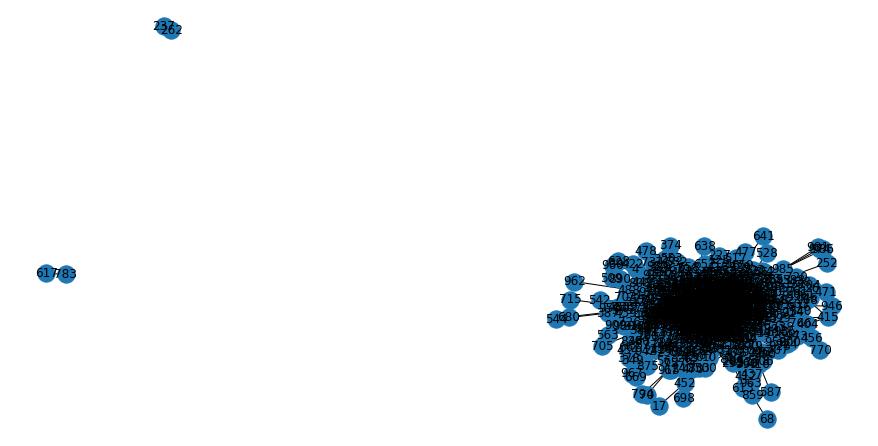

In [8]:

### for s = 0.05
#########################

matplotlib.rcParams['figure.figsize'] = [12, 6]

edges1 = unw1_k10['candidates']
G1 = nx.Graph()
G1.add_edges_from(edges1)
nx.draw(G1,with_labels = True)

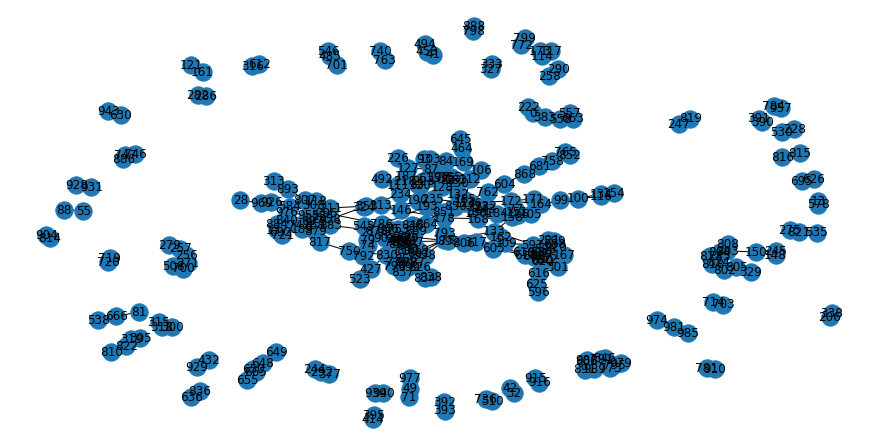

In [9]:

### for s = 0.1
#########################

matplotlib.rcParams['figure.figsize'] = [12, 6]

edges2 = unw2_k10['candidates']
G2 = nx.Graph()
G2.add_edges_from(edges2)
nx.draw(G2,with_labels = True)

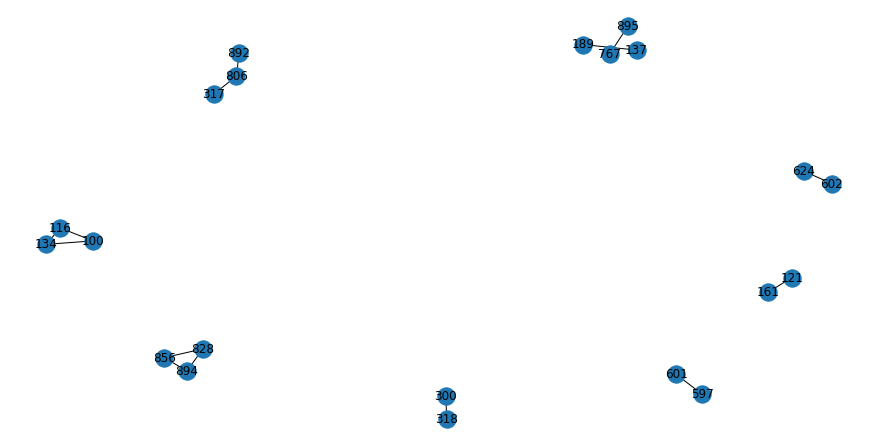

In [10]:
### for s = 0.2
#########################

matplotlib.rcParams['figure.figsize'] = [12, 6]

edges3 = unw3_k10['candidates']
G3 = nx.Graph()
G3.add_edges_from(edges3)
nx.draw(G3,with_labels = True)

2. From the basket list of authors/editors, using A-Priori or PCY, create a weighted network, using the support threshold as weight.

Task2 will save a file call anthology_authors.csv in the current folder. This is what we are going to use, working from the same folder as Task2

In [13]:
# initializing out list 

s_list = []
L2_counts_list = []
Wall_time_list_ns = []


####
###### for supports s = 12 (s = 0.05 - 0.2 are taking too long to run and most of them generating memory error 
####### [crashing the notebook])

s = 12
L2_s12 = pcy_items(s)


####
###### for supports s = 15 

#s = 15
#L2_s15 = pcy_items(s)



####
###### for supports s = 20 

#s = 20
#L2_s20 = pcy_items(s)

In [14]:
len(L2_s12) #we are going o use this only since it has enough data points

246

In [15]:
#################
#################   For PCY threshhold 12 but using 0.05 for tuple similarity
#####################################


# conver frozenset to list
test_ndiList1 = list(L2_s12)

# joint each item of the list so we can compare later the jaccard distance with others
test_ndiList1_New = []
for i in range(len(test_ndiList1)):
    z=list(test_ndiList1[i])
    z = z[0]+ z[1]
    test_ndiList1_New.append(z)
    

#test_ndiList1_New [:5]

k=10
w1_k10 = jacc_dist_calc(test_ndiList1_New,k=k,s=0.05,bands=bands,rows=rows)

w1_k10[:3]

,s,candidates,jacc_distance
0,0.05,"(0, 1)",0.8
1,0.05,"(0, 24)",0.6
2,0.05,"(0, 77)",0.8


In [16]:
# extracting the first and second elements of the candidate tuple as n1 and n2
n1 = []
n2 = []

for c in range(len(w1_k10['candidates'])):
    n1.append(w1_k10['candidates'][c][0])
    

for c in range(len(w1_k10['candidates'])):
    n2.append(w1_k10['candidates'][c][1])    

    
# extracting distances in the above dataframe corresponding to the tuples to be used as weights
w = []
for c in range(len(w1_k10['jacc_distance'])):
    w.append(w1_k10['jacc_distance'][c])
       
        
# writing these three list into a text file

xarray = np.array(n1)
yarray = np.array(n2)
zarray = np.array(w)

# here the data, in three numpy arrays
data11 = np.column_stack([xarray, yarray, zarray])
datafile_path = "WeightedFile11.txt"
np.savetxt(datafile_path , data11, fmt=['%d','%d', '%2.3f'])
# here the ascii file is written. 


# read data
data11 = np.loadtxt("WeightedFile11.txt") # i have floats in the jaccard distance, so i removed astype(int)
print(data11)        
        

[[  0.      1.      0.8  ]
 [  0.     24.      0.6  ]
 [  0.     77.      0.8  ]
 ...
 [233.    234.      0.773]
 [235.    242.      0.688]
 [241.    243.      0.889]]


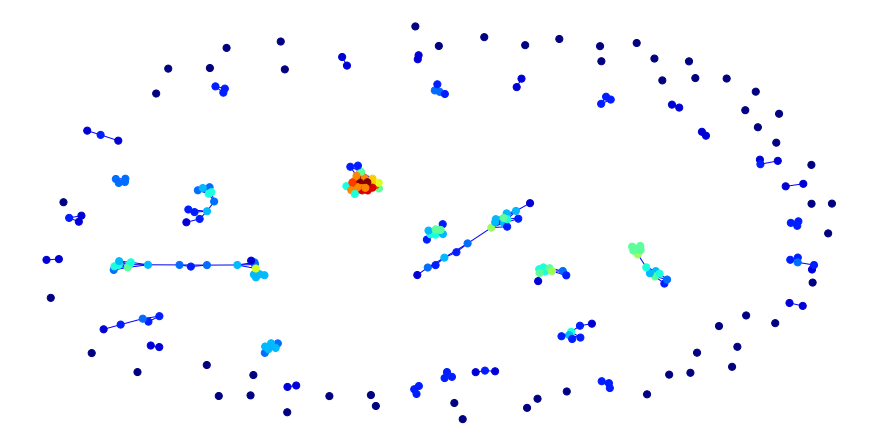

In [17]:

# make the graph
N = 240    # nodes
w1 = 0.7    # threshold's weight 

G11 = nx.Graph()
for i in range(1, N):
    G11.add_node(i)
for n1, n2, w in data11:
    if w >= w1:
        G11.add_edge(n1, n2, weight=w)
        
# the plot
matplotlib.rcParams['figure.figsize'] = [12, 6]

# show graph
node_degrees_1 = nx.degree(G11)
#node_degrees = list(dict(node_degrees_1).values())  # this code has: TypeError: 'dict' object is not callable, so i spurn the next code
node_degrees = [val for (node, val) in node_degrees_1]
nx.draw(G11, node_size=50, edge_color="b", cmap=plt.get_cmap('jet'), node_color = node_degrees)
plt.show()        
        
        

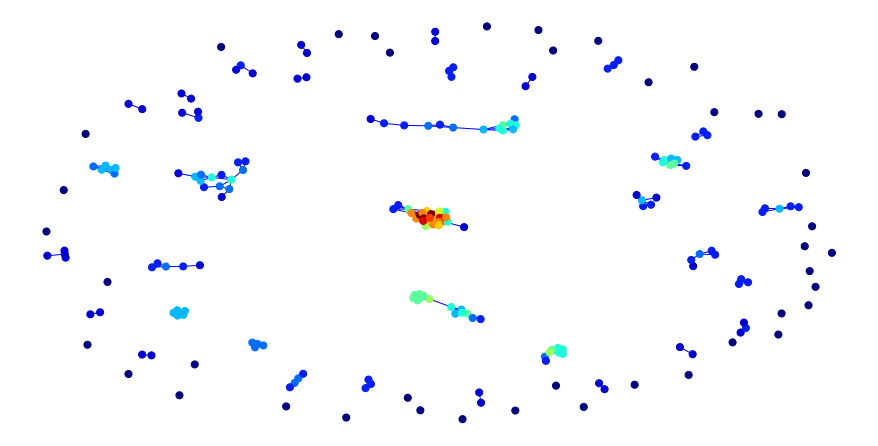

In [18]:
#################
#################   For PCY threshhold 12 but using 0.1 for tuple similarity
#####################################


k=10
w1_k10 = jacc_dist_calc(test_ndiList1_New,k=k,s=0.1,bands=bands,rows=rows)


# extracting the first and second elements of the candidate tuple as n1 and n2
n1 = []
n2 = []

for c in range(len(w1_k10['candidates'])):
    n1.append(w1_k10['candidates'][c][0])
    

for c in range(len(w1_k10['candidates'])):
    n2.append(w1_k10['candidates'][c][1])    

    
# extracting distances in the above dataframe corresponding to the tuples to be used as weights
w = []
for c in range(len(w1_k10['jacc_distance'])):
    w.append(w1_k10['jacc_distance'][c])
       
        
# writing these three list into a text file

xarray = np.array(n1)
yarray = np.array(n2)
zarray = np.array(w)

# here the data, in three numpy arrays
data22 = np.column_stack([xarray, yarray, zarray])
datafile_path = "WeightedFile22.txt"
np.savetxt(datafile_path , data22, fmt=['%d','%d', '%2.3f'])
# here the ascii file is written. 


# read data
data22 = np.loadtxt("WeightedFile22.txt") # i have floats in the jaccard distance, so i removed astype(int)
#print(data)        
 

# make the graph
N = 132    # nodes; this data file has 132
w1 = 0.7    # threshold's weight 

G22 = nx.Graph()
for i in range(1, N):
    G22.add_node(i)
for n1, n2, w in data22:
    if w >= w1:
        G22.add_edge(n1, n2, weight=w)
        
# the plot
matplotlib.rcParams['figure.figsize'] = [12, 6]

# show graph
node_degrees_1 = nx.degree(G22)
#node_degrees = list(dict(node_degrees_1).values())  # this code has: TypeError: 'dict' object is not callable, so i spurn the next code
node_degrees = [val for (node, val) in node_degrees_1]
nx.draw(G22, node_size=50, edge_color="b", cmap=plt.get_cmap('jet'), node_color = node_degrees)
plt.show()     

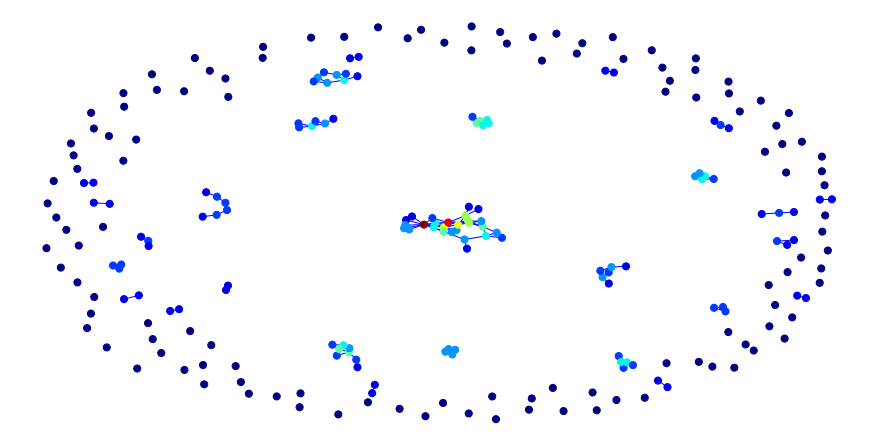

In [19]:
#################
#################   For PCY threshhold 12 but using 0.2 for tuple similarity
#####################################

k=10
w1_k10 = jacc_dist_calc(test_ndiList1_New,k=k,s=0.2,bands=bands,rows=rows)


# extracting the first and second elements of the candidate tuple as n1 and n2
n1 = []
n2 = []

for c in range(len(w1_k10['candidates'])):
    n1.append(w1_k10['candidates'][c][0])
    

for c in range(len(w1_k10['candidates'])):
    n2.append(w1_k10['candidates'][c][1])    

    
# extracting distances in the above dataframe corresponding to the tuples to be used as weights
w = []
for c in range(len(w1_k10['jacc_distance'])):
    w.append(w1_k10['jacc_distance'][c])
       
        
# writing these three list into a text file

xarray = np.array(n1)
yarray = np.array(n2)
zarray = np.array(w)

# here the data, in three numpy arrays
data33 = np.column_stack([xarray, yarray, zarray])
datafile_path = "WeightedFile33.txt"
np.savetxt(datafile_path , data33, fmt=['%d','%d', '%2.3f'])
# here the ascii file is written. 


# read data
data33 = np.loadtxt("WeightedFile33.txt") # i have floats in the jaccard distance, so i removed astype(int)
#print(data)        
 

# make the graph
N = 234    # nodes; this data file has 234
w1 = 0.7    # threshold's weight 

G33 = nx.Graph()
for i in range(1, N):
    G33.add_node(i)
for n1, n2, w in data33:
    if w >= w1:
        G33.add_edge(n1, n2, weight=w)
        
# the plot
matplotlib.rcParams['figure.figsize'] = [12, 6]

# show graph
node_degrees_1 = nx.degree(G33)
#node_degrees = list(dict(node_degrees_1).values())  # this code has: TypeError: 'dict' object is not callable, so i spurn the next code
node_degrees = [val for (node, val) in node_degrees_1]
nx.draw(G33, node_size=50, edge_color="b", cmap=plt.get_cmap('jet'), node_color = node_degrees)
plt.show()     

3. Find the communities for the networks obtained in 1. and 2. Comment about the results with respect to the different thresholds and methods. How does it compare with the same analysis using 1-NN done in previous tasks?

##### communities  or clusters for the networks obtained in 1. for s = 0.05

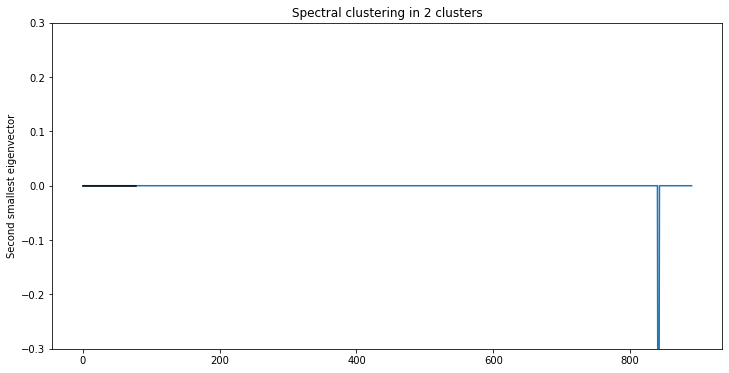

In [20]:

L1 = nx.laplacian_matrix(G1).toarray()

# find eigenvectors of Laplacian matrix,
# take second smallest and third smallest
u,s,v = np.linalg.svd(L1)
ev2 = u[:, -2]
ev3 = u[:, -3]


# print second smallest eigenvector
plt.plot(ev2)
plt.ylim([-0.3, 0.3])
plt.plot([0, 78], [0, 0], '-k')
plt.title("Spectral clustering in 2 clusters")
plt.ylabel("Second smallest eigenvector")
plt.show()

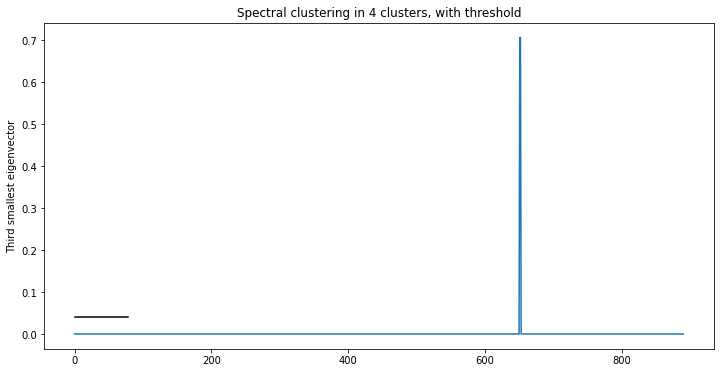

In [21]:
# print third smallest eigenvector
plt.plot(ev3)
plt.plot([0, 78], [0.04, 0.04], '-k')
plt.title("Spectral clustering in 4 clusters, with threshold")
plt.ylabel("Third smallest eigenvector")
plt.show()

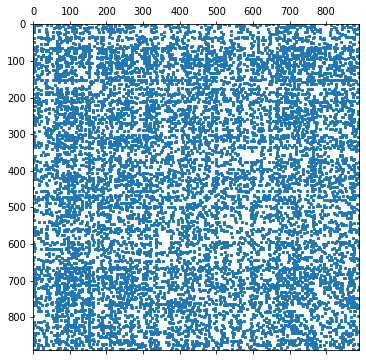

In [22]:
# adjacency matrix of un-ordered graph (JUST one examle)
N = len(G1)
ix = np.arange(N)
np.random.shuffle(ix)
A = nx.adjacency_matrix(G1)
A = A[ix,:][:,ix]
plt.spy(A, markersize=2.0)

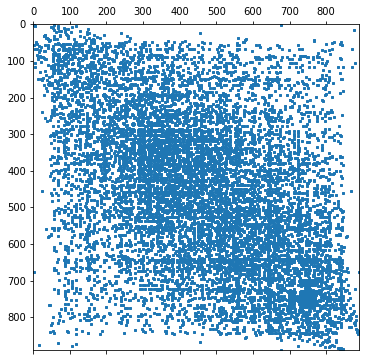

In [23]:
# adjacency matrix ordered by 2nd smallest eigenvector
ix = np.argsort(ev2)
A = nx.adjacency_matrix(G1)
A = A[ix,:][:,ix]
plt.spy(A, markersize=2.0)

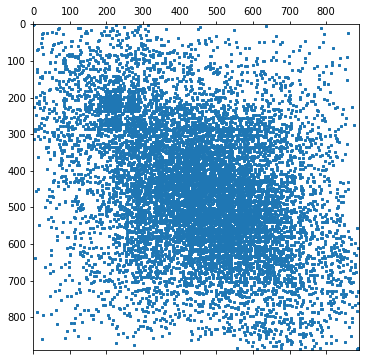

In [24]:
# adjacency matrix ordered by 3rd smallest eigenvector
ix = np.argsort(ev3)
A = nx.adjacency_matrix(G1)
A = A[ix,:][:,ix]
plt.spy(A, markersize=2.0)

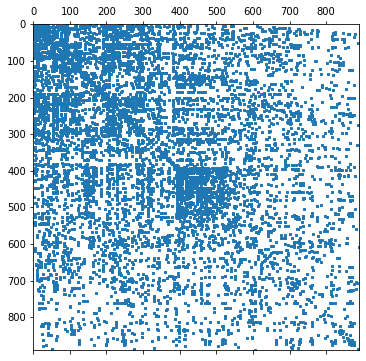

In [25]:
# ideal adjacency matrix (from the original dataset)
A = nx.adjacency_matrix(G1)
plt.spy(A, markersize=2.0)

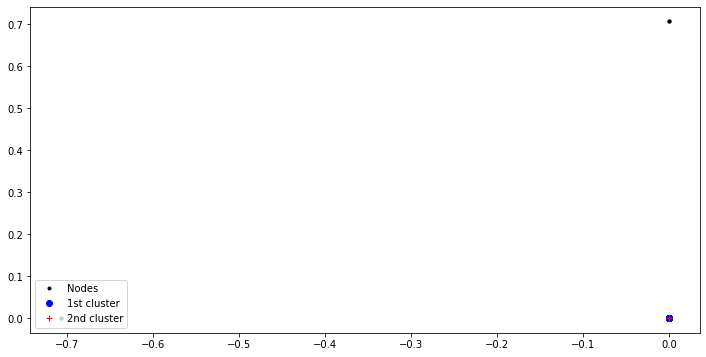

In [26]:
# graph shown in coordinates of two last eigenvectors
vert = dict(nx.degree(G1)).keys()
plt.plot(ev2[2:], ev3[2:], '.k')
plt.plot(ev2[2:18], ev3[2:18], 'ob')
plt.plot(ev2[18:45], ev3[18:45], '+r')
plt.legend(['Nodes', '1st cluster', '2nd cluster'], loc=3)
plt.show()

##### communities  or clusters for the networks obtained in 1. for s = 0.1

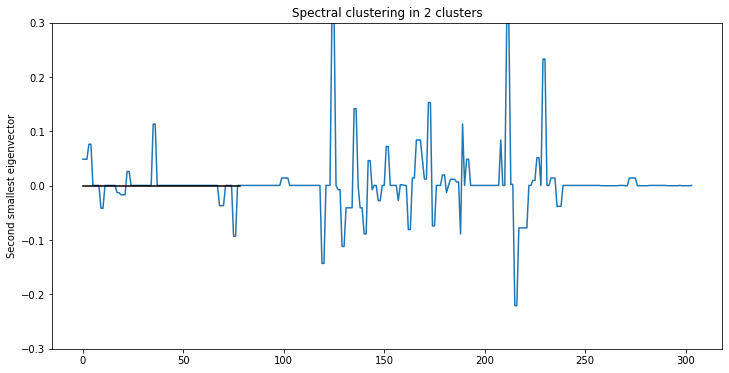

In [27]:
L2 = nx.laplacian_matrix(G2).toarray()

# find eigenvectors of Laplacian matrix,
# take second smallest and third smallest
u,s,v = np.linalg.svd(L2)
ev2 = u[:, -2]
ev3 = u[:, -3]


# print second smallest eigenvector
plt.plot(ev2)
plt.ylim([-0.3, 0.3])
plt.plot([0, 78], [0, 0], '-k')
plt.title("Spectral clustering in 2 clusters")
plt.ylabel("Second smallest eigenvector")
plt.show()

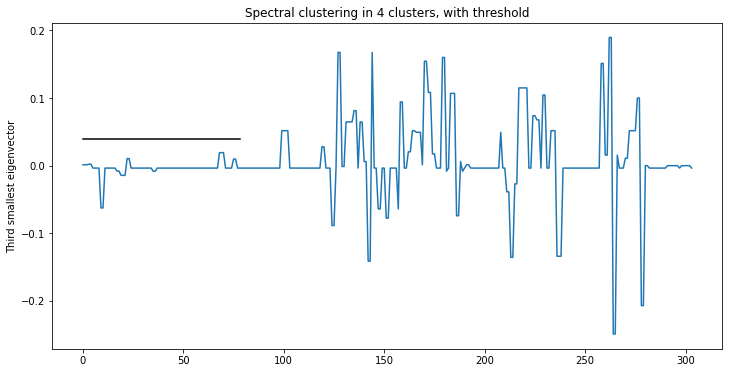

In [28]:
# print third smallest eigenvector
plt.plot(ev3)
plt.plot([0, 78], [0.04, 0.04], '-k')
plt.title("Spectral clustering in 4 clusters, with threshold")
plt.ylabel("Third smallest eigenvector")
plt.show()

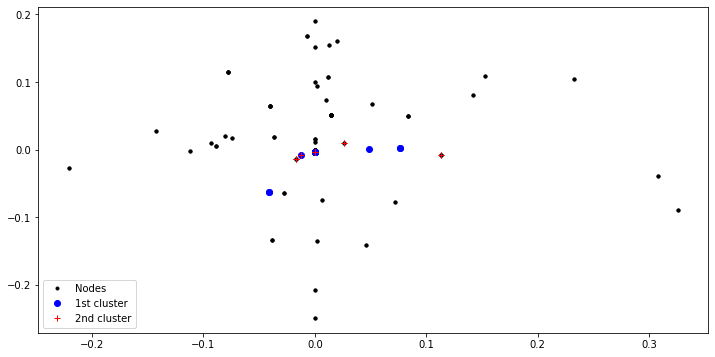

In [29]:
# graph shown in coordinates of two last eigenvectors
vert = dict(nx.degree(G2)).keys()
plt.plot(ev2[2:], ev3[2:], '.k')
plt.plot(ev2[2:18], ev3[2:18], 'ob')
plt.plot(ev2[18:45], ev3[18:45], '+r')
plt.legend(['Nodes', '1st cluster', '2nd cluster'], loc=3)
plt.show()

##### communities  or clusters for the networks obtained in 1. for s = 0.2

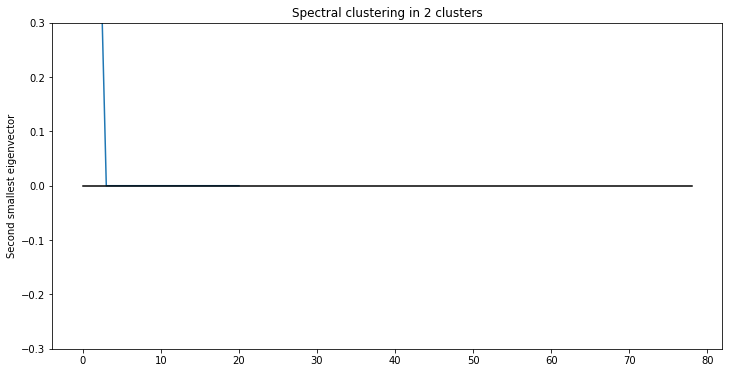

In [30]:
L3 = nx.laplacian_matrix(G3).toarray()

# find eigenvectors of Laplacian matrix,
# take second smallest and third smallest
u,s,v = np.linalg.svd(L3)
ev2 = u[:, -2]
ev3 = u[:, -3]


# print second smallest eigenvector
plt.plot(ev2)
plt.ylim([-0.3, 0.3])
plt.plot([0, 78], [0, 0], '-k')
plt.title("Spectral clustering in 2 clusters")
plt.ylabel("Second smallest eigenvector")
plt.show()

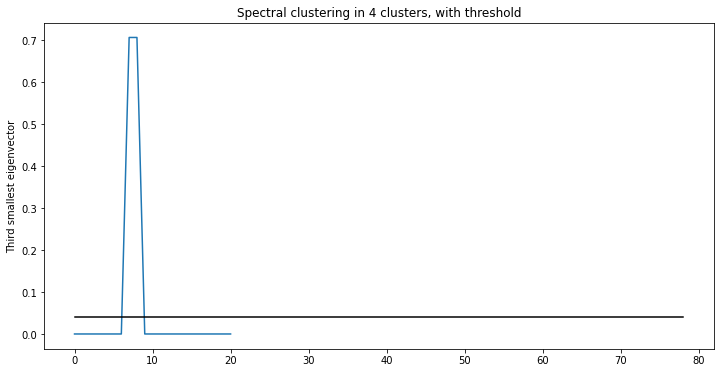

In [31]:
# print third smallest eigenvector
plt.plot(ev3)
plt.plot([0, 78], [0.04, 0.04], '-k')
plt.title("Spectral clustering in 4 clusters, with threshold")
plt.ylabel("Third smallest eigenvector")
plt.show()

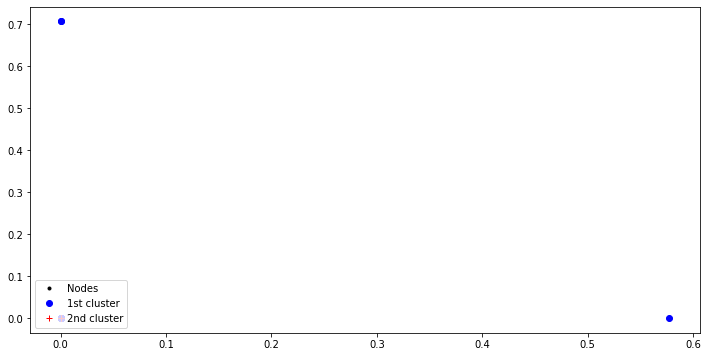

In [32]:
# graph shown in coordinates of two last eigenvectors
vert = dict(nx.degree(G3)).keys()
plt.plot(ev2[2:], ev3[2:], '.k')
plt.plot(ev2[2:18], ev3[2:18], 'ob')
plt.plot(ev2[18:45], ev3[18:45], '+r')
plt.legend(['Nodes', '1st cluster', '2nd cluster'], loc=3)
plt.show()

##### communities  or clusters for the networks obtained in 2. for s = 0.05

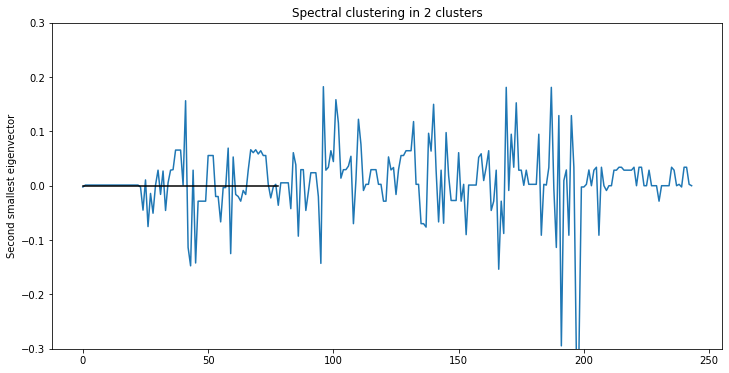

In [33]:
L11 = nx.laplacian_matrix(G11).toarray()

# find eigenvectors of Laplacian matrix,
# take second smallest and third smallest
u,s,v = np.linalg.svd(L11)
ev2 = u[:, -2]
ev3 = u[:, -3]


# print second smallest eigenvector
plt.plot(ev2)
plt.ylim([-0.3, 0.3])
plt.plot([0, 78], [0, 0], '-k')
plt.title("Spectral clustering in 2 clusters")
plt.ylabel("Second smallest eigenvector")
plt.show()

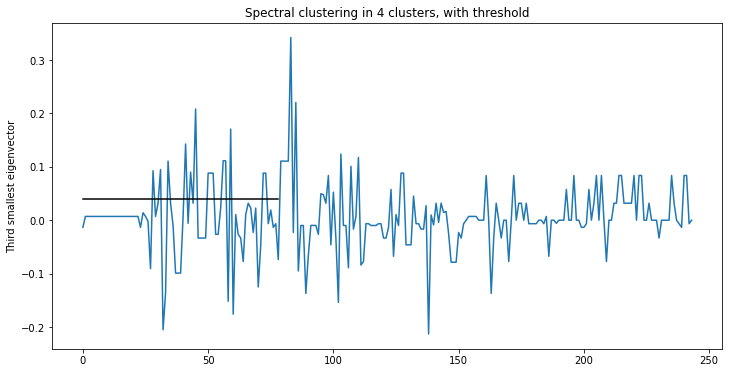

In [34]:
# print third smallest eigenvector
plt.plot(ev3)
plt.plot([0, 78], [0.04, 0.04], '-k')
plt.title("Spectral clustering in 4 clusters, with threshold")
plt.ylabel("Third smallest eigenvector")
plt.show()

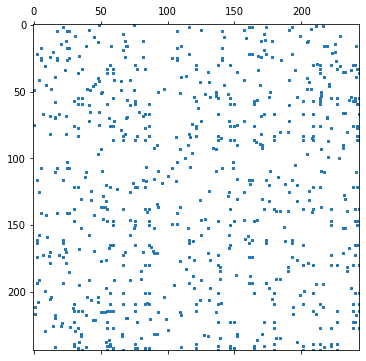

In [35]:
# adjacency matrix of un-ordered graph (JUST one examle)

N = len(G11)
ix = np.arange(N)
np.random.shuffle(ix)
A = nx.adjacency_matrix(G11)
A = A[ix,:][:,ix]
plt.spy(A, markersize=2.0)

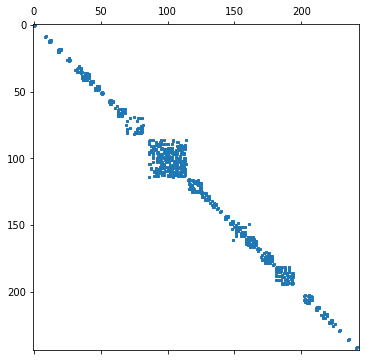

In [36]:
# adjacency matrix ordered by 2nd smallest eigenvector
ix = np.argsort(ev2)
A = nx.adjacency_matrix(G11)
A = A[ix,:][:,ix]
plt.spy(A, markersize=2.0)

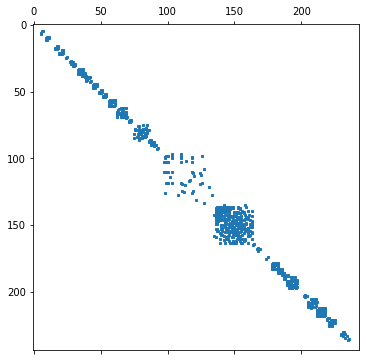

In [37]:
# adjacency matrix ordered by 3rd smallest eigenvector
ix = np.argsort(ev3)
A = nx.adjacency_matrix(G11)
A = A[ix,:][:,ix]
plt.spy(A, markersize=2.0)

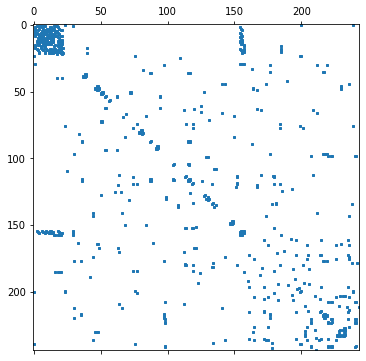

In [38]:
# ideal adjacency matrix (from the original dataset)
A = nx.adjacency_matrix(G11)
plt.spy(A, markersize=2.0)

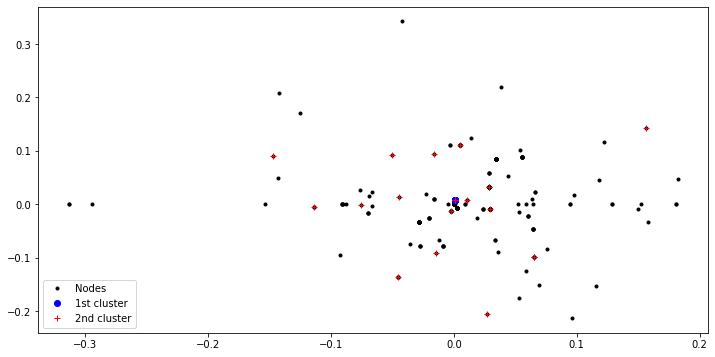

In [39]:
# graph shown in coordinates of two last eigenvectors
vert = dict(nx.degree(G11)).keys()
plt.plot(ev2[2:], ev3[2:], '.k')
plt.plot(ev2[2:18], ev3[2:18], 'ob')
plt.plot(ev2[18:45], ev3[18:45], '+r')
plt.legend(['Nodes', '1st cluster', '2nd cluster'], loc=3)
plt.show()

##### communities  or clusters for the networks obtained in 2. for s = 0.1

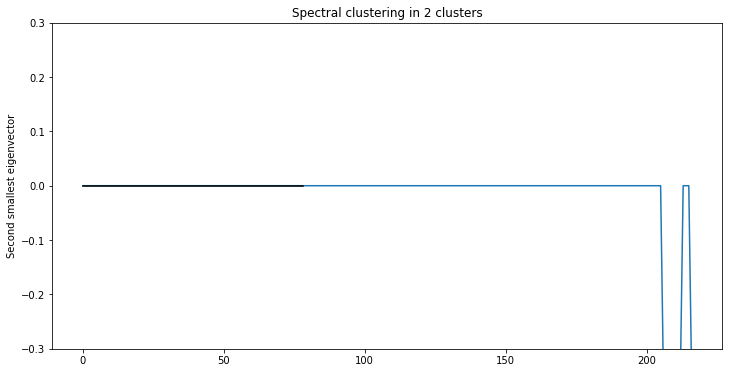

In [40]:
L22 = nx.laplacian_matrix(G22).toarray()

# find eigenvectors of Laplacian matrix,
# take second smallest and third smallest
u,s,v = np.linalg.svd(L22)
ev2 = u[:, -2]
ev3 = u[:, -3]


# print second smallest eigenvector
plt.plot(ev2)
plt.ylim([-0.3, 0.3])
plt.plot([0, 78], [0, 0], '-k')
plt.title("Spectral clustering in 2 clusters")
plt.ylabel("Second smallest eigenvector")
plt.show()

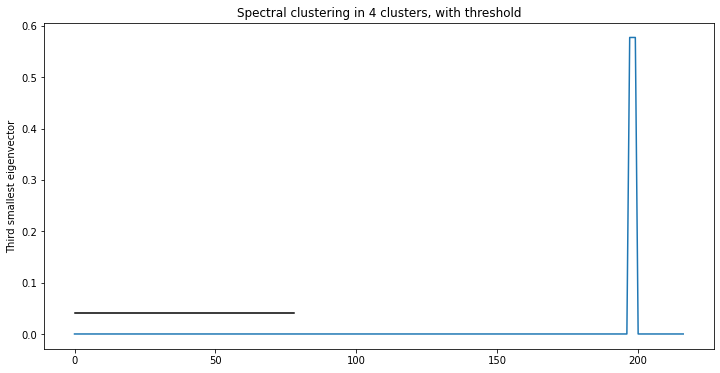

In [41]:
# print third smallest eigenvector
plt.plot(ev3)
plt.plot([0, 78], [0.04, 0.04], '-k')
plt.title("Spectral clustering in 4 clusters, with threshold")
plt.ylabel("Third smallest eigenvector")
plt.show()

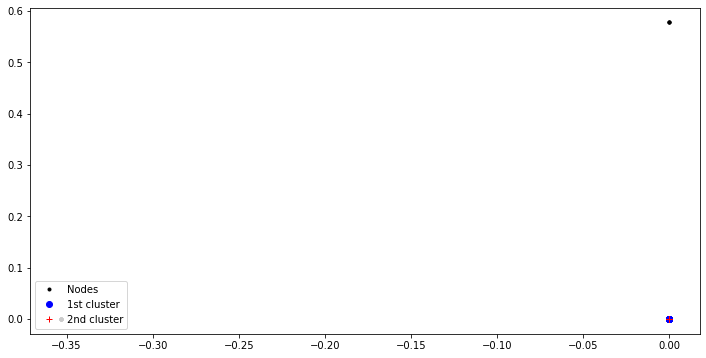

In [42]:
# graph shown in coordinates of two last eigenvectors
vert = dict(nx.degree(G22)).keys()
plt.plot(ev2[2:], ev3[2:], '.k')
plt.plot(ev2[2:18], ev3[2:18], 'ob')
plt.plot(ev2[18:45], ev3[18:45], '+r')
plt.legend(['Nodes', '1st cluster', '2nd cluster'], loc=3)
plt.show()

##### communities  or clusters for the networks obtained in 2. for s = 0.2

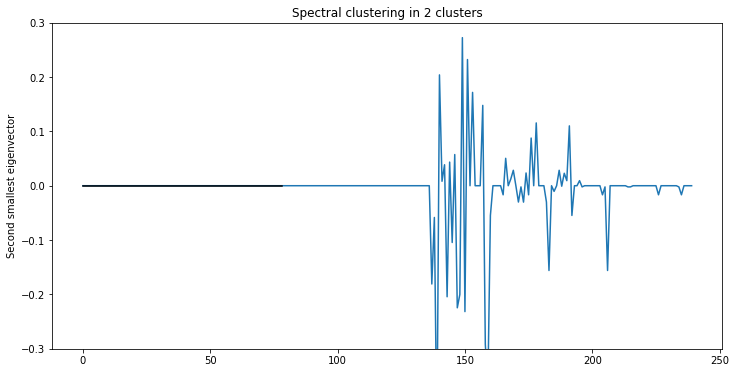

In [43]:
L33 = nx.laplacian_matrix(G33).toarray()

# find eigenvectors of Laplacian matrix,
# take second smallest and third smallest
u,s,v = np.linalg.svd(L33)
ev2 = u[:, -2]
ev3 = u[:, -3]


# print second smallest eigenvector
plt.plot(ev2)
plt.ylim([-0.3, 0.3])
plt.plot([0, 78], [0, 0], '-k')
plt.title("Spectral clustering in 2 clusters")
plt.ylabel("Second smallest eigenvector")
plt.show()

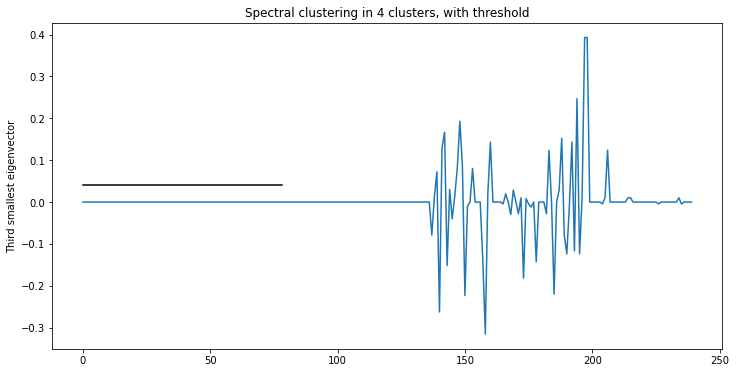

In [44]:
# print third smallest eigenvector
plt.plot(ev3)
plt.plot([0, 78], [0.04, 0.04], '-k')
plt.title("Spectral clustering in 4 clusters, with threshold")
plt.ylabel("Third smallest eigenvector")
plt.show()

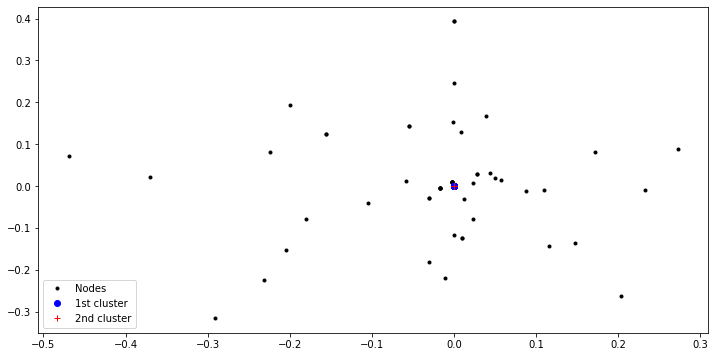

In [45]:
# graph shown in coordinates of two last eigenvectors
vert = dict(nx.degree(G33)).keys()
plt.plot(ev2[2:], ev3[2:], '.k')
plt.plot(ev2[2:18], ev3[2:18], 'ob')
plt.plot(ev2[18:45], ev3[18:45], '+r')
plt.legend(['Nodes', '1st cluster', '2nd cluster'], loc=3)
plt.show()

COMMENT

- The un-weighted and weighed network graphs in 1. and 2. above respectively shows dense clusters with lower thresholds which gets dispersed as the threshold increases. These clusters began with a few thirties to forties of them
- But the spectral clustering shows less clusters with lower thresholds and more as the threshold increases; this is like a kind of zoom-in to the massive clustering seen in the unweighed and weighted sections above
- It does compares favourably with the 1-NN done previously because the previous yielded about 288 total clusters (disparse nodes inclusive; although 122 fully formed clusters without the disparsed nodes); although we didn't search for the larger ones which could have been in the thirties to forties. This one shows the eigenvectors length of about 238. This is fairly close.

4. Use a ready-made software, library or service (eg. gephi) for visualizing one the network in 1. or 2.Comment your results.

- Using Cytoscape with my weighted network files for support threshold s = 0.05(WeightedFile11.txt), 0.1(WeightedFile22.txt) and 0.2(WeightedFile33.txt)



- We achieved for s = 0.05; 37 clusters


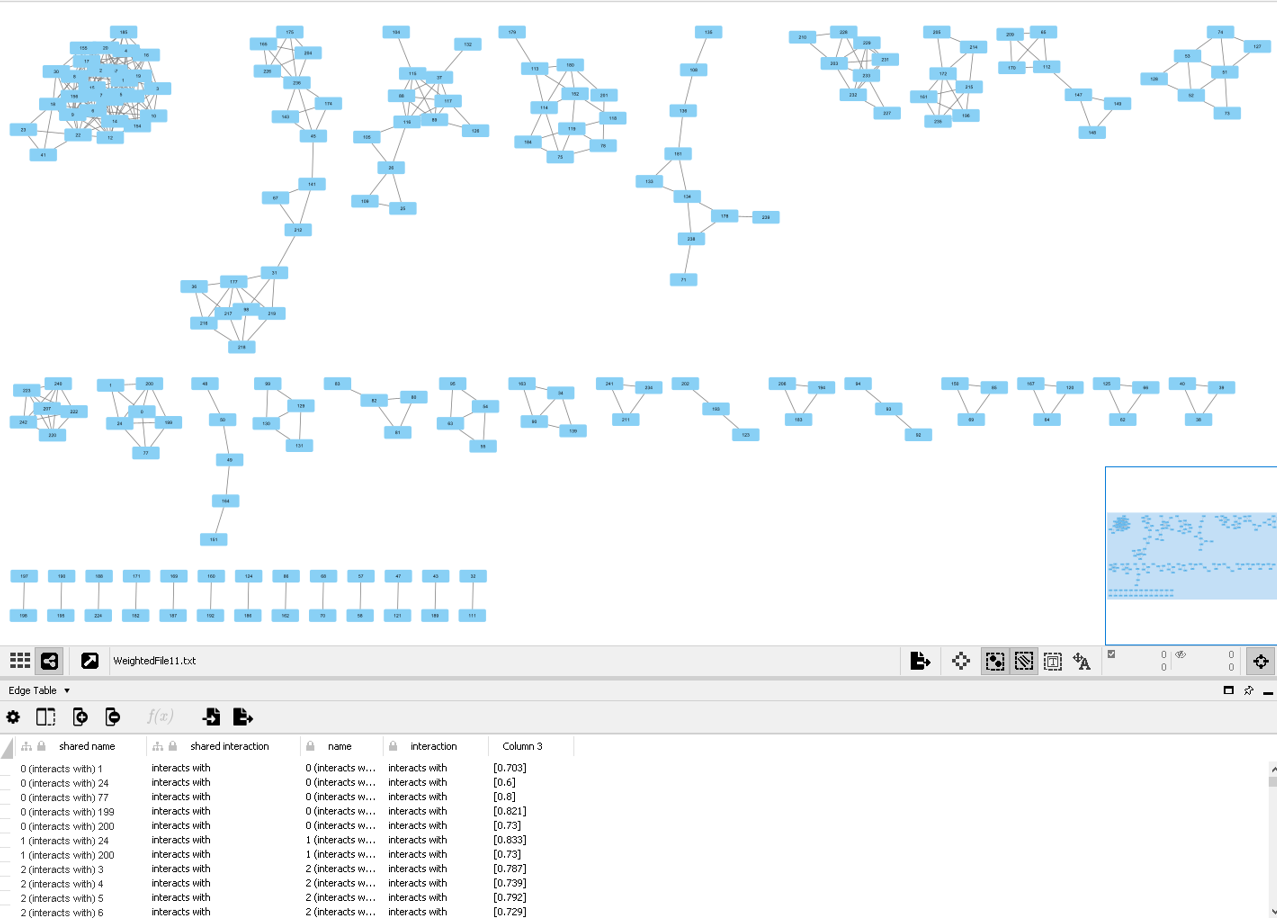

- We achieved for s = 0.1; 40 clusters


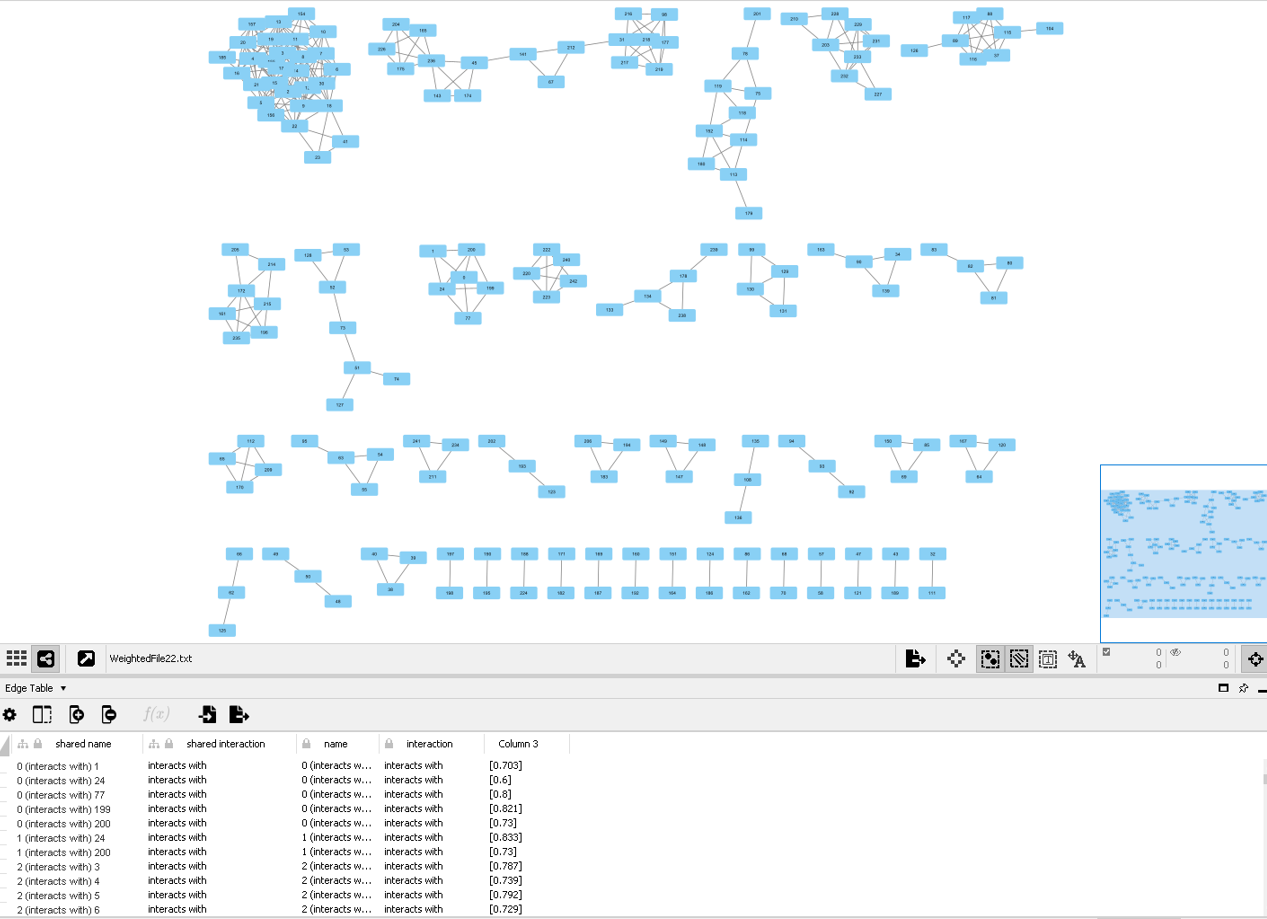

- We achieved for s = 0.2; 41 clusters


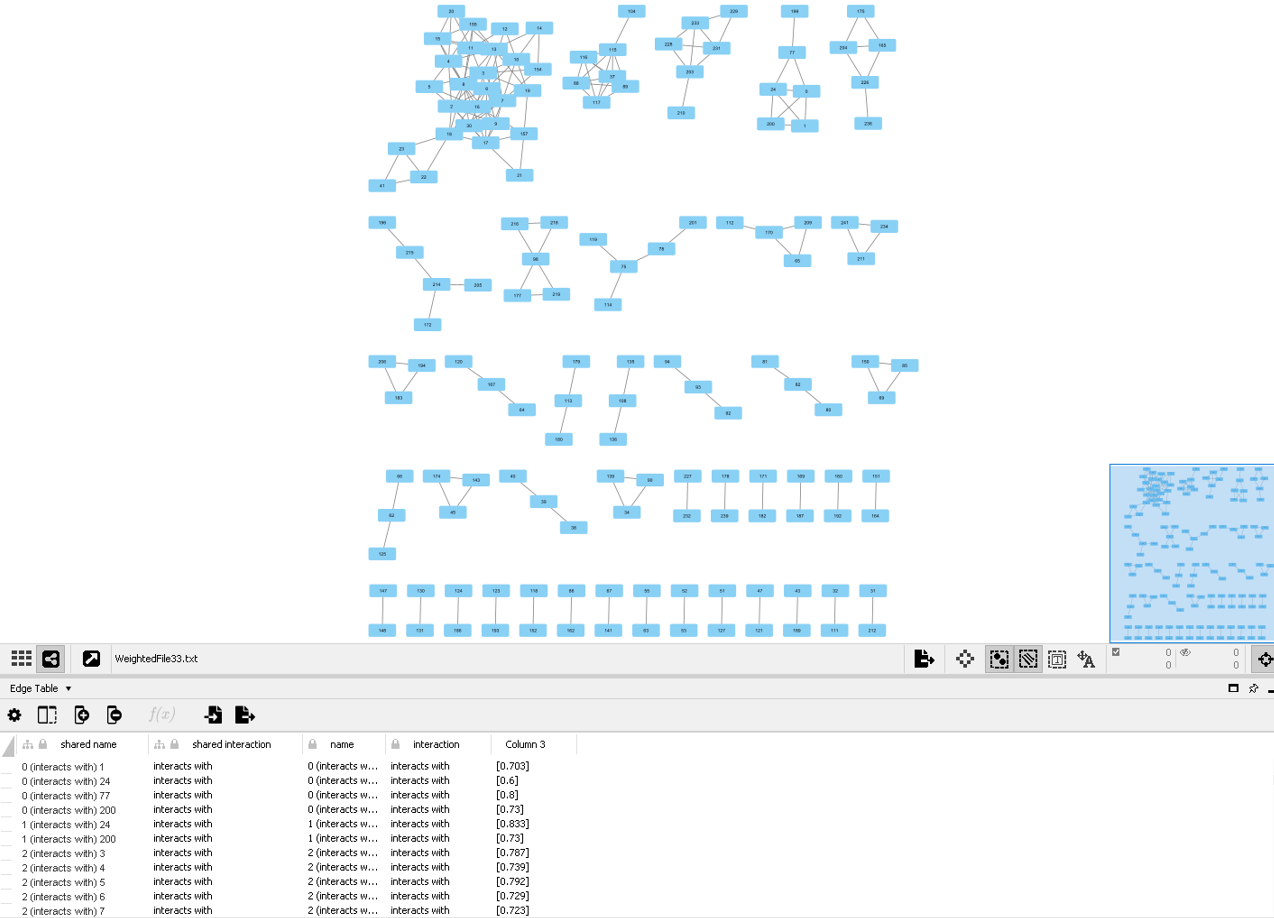

COMMENT

- The first and second clusters for each of them (first and second lines clusters) are: 24, 23 and 17 respectively. showing that as the threshold s increases, the main clusters gets lesser; which should be.
- I believe this method of dedicated software is quicker and generalising well enough by dealing with the best of them compared with the 1-NN we earlier did (which was time cumbersome and carried along every tom, dick and harry of a cluster (being granulla). I guess they all serve different purposes. 1-NN for granullarity but weighted network graphs, spectral clustering and cytoscape for generalization.